## Wild test

This is the assessment of how well the model generalizes on real-life images. The logic behind: raw predictions → confidence → metrics → interpretation

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
# constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
MODEL_PATH = Path("../models/v3-1_best.keras")

In [3]:
# functions

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)  # keep 0..255, model does preprocessing
    return img, label

def make_dataset(paths, labels, shuffle=False):
    paths = np.array([str(p) for p in paths])
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000, reshuffle_each_iteration=False)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

In [4]:
# load model
model = tf.keras.models.load_model(MODEL_PATH, safe_mode=False)
print("Loaded:", type(model))
model.summary()




Loaded: <class 'keras.src.engine.functional.Functional'>
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentation (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 preprocess_input (Lambda)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                12810     


In [5]:
import json

with open(Path("../data/splits/class_names.json"), "r") as f:
    class_names = json.load(f)


In [6]:
# load splits and prepare dataset

split_dir = Path("../data/splits")
wild_test_paths  = np.load(split_dir / "wild_test_paths.npy", allow_pickle=True)
wild_test_labels = np.load(split_dir / "wild_test_labels.npy")

y_true = wild_test_labels.astype(int)
wild_test_ds = make_dataset(wild_test_paths, wild_test_labels, shuffle=False)


In [7]:
probs_all = model.predict(wild_test_ds, verbose=1)
y_pred = np.argmax(probs_all, axis=1)
y_pred_conf = np.max(probs_all, axis=1)

print("\nConfidence statistics:")
print(f"  Mean confidence:   {y_pred_conf.mean():.3f}")
print(f"  Median confidence: {np.median(y_pred_conf):.3f}")
print(f"  Min confidence:    {y_pred_conf.min():.3f}")
print(f"  Max confidence:    {y_pred_conf.max():.3f}")


2/2 [==============================] - 2s 222ms/step

Confidence statistics:
  Mean confidence:   0.752
  Median confidence: 0.784
  Min confidence:    0.291
  Max confidence:    1.000


In [8]:
import pandas as pd

df_conf = pd.DataFrame({
    "correct": (y_true == y_pred),
    "conf": y_pred_conf
})

bins = [0.0, 0.5, 0.7, 0.85, 1.0]
df_conf["conf_bin"] = pd.cut(df_conf["conf"], bins=bins, include_lowest=True)

acc_by_bin = df_conf.groupby("conf_bin", observed=True)["correct"].mean()

print("\nAccuracy by confidence bin:")
print(acc_by_bin)



Accuracy by confidence bin:
conf_bin
(-0.001, 0.5]    0.285714
(0.5, 0.7]       0.428571
(0.7, 0.85]      0.411765
(0.85, 1.0]      0.733333
Name: correct, dtype: float64


In [9]:
acc = accuracy_score(y_true, y_pred)
print("Wild accuracy:", acc)

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix (rows=true, cols=pred):")
print(cm)


Wild accuracy: 0.5

Classification report:
                                      precision    recall  f1-score   support

                      Bacterial_spot       0.50      0.20      0.29         5
                        Early_blight       0.27      0.60      0.37         5
                         Late_blight       0.75      0.60      0.67         5
                           Leaf_Mold       1.00      0.20      0.33         5
                  Septoria_leaf_spot       0.50      0.50      0.50         4
Spider_mites_Two_spotted_spider_mite       0.50      0.75      0.60         4
                         Target_Spot       0.33      0.25      0.29         4
              YellowLeaf__Curl_Virus       0.67      0.67      0.67         3
                             healthy       0.86      0.86      0.86         7
                        mosaic_virus       0.20      0.25      0.22         4

                            accuracy                           0.50        46
                   

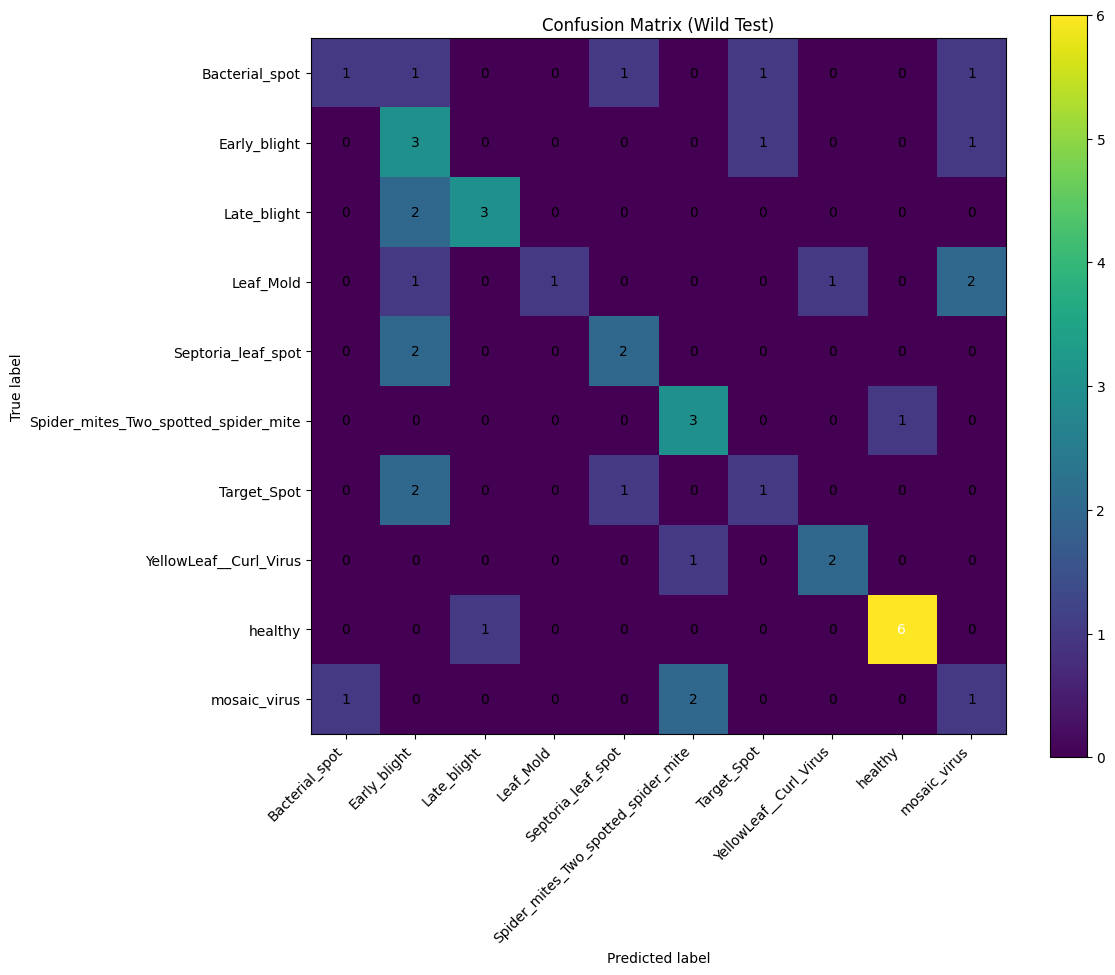

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Wild Test)")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

# Add numbers in each cell
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, format(cm[i, j], "d"),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()


## Discarded stuff from the previous version (wild test data from a separate folder)

In [ ]:
# 2) Class mapping (must match training order) - not used in this notebook but useful to have
class_names = [
    "Bacterial_spot",
    "Early_blight",
    "Late_blight",
    "Leaf_Mold",
    "Septoria_leaf_spot",
    "Spider_mites_Two_spotted_spider_mite",
    "Target_Spot",
    "YellowLeaf__Curl_Virus",
    "healthy",
    "mosaic_virus",
]
class_to_idx = {c: i for i, c in enumerate(class_names)}

In [ ]:
# 4) Collect image files + labels from folder structure - not used in this notebook but useful to have
img_paths = []
y_true = []

valid_ext = {".jpg", ".jpeg", ".png", ".webp"}

for cls in class_names:
    cls_dir = WILD_DIR / cls
    if not cls_dir.exists():
        print(f"WARNING: Missing folder: {cls_dir}")
        continue

    for p in cls_dir.rglob("*"):
        if p.suffix.lower() in valid_ext:
            img_paths.append(p)
            y_true.append(class_to_idx[cls])

img_paths = np.array(img_paths, dtype=object)
y_true = np.array(y_true, dtype=int)

print("Wild images found:", len(img_paths))
if len(img_paths) == 0:
    raise ValueError("No images found. Check WILD_DIR and folder names.")

Wild images found: 50


In [23]:
# 5) Image loader (RGB + resize)
#IMG_SIZE = (256, 256) #for CNN model
IMG_SIZE = (224, 224)  # for pretrained model

def load_one_image(path: Path) -> tf.Tensor:
    raw = tf.io.read_file(str(path))
    img = tf.image.decode_image(raw, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)  # keep as float; model has Rescaling inside
    return img

In [ ]:
# 6) Predict in batches (store probs too) - not used in this notebook but useful to have
BATCH = 16
probs_all = []

for i in range(0, len(img_paths), BATCH):
    batch_paths = img_paths[i:i+BATCH]
    batch_imgs = tf.stack([load_one_image(p) for p in batch_paths], axis=0)
    probs = model.predict(batch_imgs, verbose=0)
    probs_all.append(probs)

probs_all = np.vstack(probs_all)               # shape: (N, num_classes)
y_pred = np.argmax(probs_all, axis=1)          # predicted class index
y_pred_conf = np.max(probs_all, axis=1)        # confidence of predicted class

print("\nConfidence statistics:")
print(f"  Mean confidence:   {y_pred_conf.mean():.3f}")
print(f"  Median confidence: {np.median(y_pred_conf):.3f}")
print(f"  Min confidence:    {y_pred_conf.min():.3f}")
print(f"  Max confidence:    {y_pred_conf.max():.3f}")


Confidence statistics:
  Mean confidence:   0.718
  Median confidence: 0.749
  Min confidence:    0.274
  Max confidence:    1.000


In [25]:

# ---- Accuracy by confidence bucket ----
import pandas as pd

df_conf = pd.DataFrame({
    "correct": (y_true == y_pred),
    "conf": y_pred_conf
})

bins = [0.0, 0.5, 0.7, 0.85, 1.0]
df_conf["conf_bin"] = pd.cut(df_conf["conf"], bins=bins)

acc_by_bin = df_conf.groupby("conf_bin")["correct"].mean()

print("\nAccuracy by confidence bin:")
print(acc_by_bin)



Accuracy by confidence bin:
conf_bin
(0.0, 0.5]     0.428571
(0.5, 0.7]     0.285714
(0.7, 0.85]    0.333333
(0.85, 1.0]    0.642857
Name: correct, dtype: float64


C:\Users\ogina\AppData\Local\Temp\ipykernel_22356\987749688.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_bin = df_conf.groupby("conf_bin")["correct"].mean()


In [26]:
# 7) Metrics
acc = accuracy_score(y_true, y_pred)
print("Wild accuracy:", acc)

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix (rows=true, cols=pred):")
print(cm)

Wild accuracy: 0.42

Classification report:
                                      precision    recall  f1-score   support

                      Bacterial_spot       0.00      0.00      0.00         5
                        Early_blight       0.29      0.80      0.42         5
                         Late_blight       0.50      0.80      0.62         5
                           Leaf_Mold       0.00      0.00      0.00         5
                  Septoria_leaf_spot       0.33      0.40      0.36         5
Spider_mites_Two_spotted_spider_mite       0.75      0.60      0.67         5
                         Target_Spot       0.67      0.40      0.50         5
              YellowLeaf__Curl_Virus       0.67      0.40      0.50         5
                             healthy       1.00      0.80      0.89         5
                        mosaic_virus       0.00      0.00      0.00         5

                            accuracy                           0.42        50
                  

Finding the worst mistakes (model certain but wrong) and the most uncertain cases (ambiguous).

Total wild images: 50
Correct: 19 | Wrong: 31

=== Confident but wrong (top 12) ===


,file,true,pred,conf,top3,path
26,spider-mite-damage.jpg,Spider_mites_Two_spotted_spider_mite,Late_blight,0.996997,"[(Late_blight, 0.9969965219497681), (Early_bli...",..\data\wild_test\Spider_mites_Two_spotted_spi...
20,hgic_veg_septoria leaf spot1_1600.jpg,Septoria_leaf_spot,Early_blight,0.945933,"[(Early_blight, 0.9459333419799805), (Septoria...",..\data\wild_test\Septoria_leaf_spot\hgic_veg_...
19,leaf_mold_tomato1x1200.jpg,Leaf_Mold,Late_blight,0.902797,"[(Late_blight, 0.9027968049049377), (Early_bli...",..\data\wild_test\Leaf_Mold\leaf_mold_tomato1x...
46,mos-vir.jpg,mosaic_virus,Septoria_leaf_spot,0.882548,"[(Septoria_leaf_spot, 0.8825481534004211), (Ea...",..\data\wild_test\mosaic_virus\mos-vir.jpg
18,leaf_mold_tomato.jpg,Leaf_Mold,Late_blight,0.881289,"[(Late_blight, 0.8812889456748962), (Early_bli...",..\data\wild_test\Leaf_Mold\leaf_mold_tomato.jpg
47,mosaic-virus-apple.jpg,mosaic_virus,Bacterial_spot,0.837467,"[(Bacterial_spot, 0.8374672532081604), (health...",..\data\wild_test\mosaic_virus\mosaic-virus-ap...
2,bacterialspotontomatoXant.png,Bacterial_spot,Early_blight,0.808752,"[(Early_blight, 0.8087522983551025), (Bacteria...",..\data\wild_test\Bacterial_spot\bacterialspot...
23,Septoria_Leaf_Spot_of_Tomato186.jpg,Septoria_leaf_spot,Bacterial_spot,0.803831,"[(Bacterial_spot, 0.8038313388824463), (Septor...",..\data\wild_test\Septoria_leaf_spot\Septoria_...
17,leaf_mold_nightshade1x1200.jpg,Leaf_Mold,Bacterial_spot,0.800218,"[(Bacterial_spot, 0.8002182841300964), (Early_...",..\data\wild_test\Leaf_Mold\leaf_mold_nightsha...
11,late-blight-potato.jpg,Late_blight,Early_blight,0.757679,"[(Early_blight, 0.7576791048049927), (Bacteria...",..\data\wild_test\Late_blight\late-blight-pota...



=== Most uncertain (lowest confidence, top 12) ===


,file,true,pred,conf,top3,path
38,yellow-leaf-curl-tomato.jpg,YellowLeaf__Curl_Virus,Septoria_leaf_spot,0.293585,"[(Septoria_leaf_spot, 0.29358479380607605), (L...",..\data\wild_test\YellowLeaf__Curl_Virus\yello...
37,Yellow-leaf-curl-disease-symptom-on-Capsicum-a...,YellowLeaf__Curl_Virus,Spider_mites_Two_spotted_spider_mite,0.294412,"[(Spider_mites_Two_spotted_spider_mite, 0.2944...",..\data\wild_test\YellowLeaf__Curl_Virus\Yello...
9,Shoemaker_7068.JPG,Early_blight,Early_blight,0.333997,"[(Early_blight, 0.33399713039398193), (Target_...",..\data\wild_test\Early_blight\Shoemaker_7068.JPG
22,septoria.jpg,Septoria_leaf_spot,Septoria_leaf_spot,0.336843,"[(Septoria_leaf_spot, 0.33684346079826355), (B...",..\data\wild_test\Septoria_leaf_spot\septoria.jpg
4,bact_spot_the_daily_garden.png,Bacterial_spot,Bacterial_spot,0.339457,"[(Bacterial_spot, 0.3394569754600525), (Early_...",..\data\wild_test\Bacterial_spot\bact_spot_the...
28,two-spotted-spider-mite-tomato.jpg,Spider_mites_Two_spotted_spider_mite,Spider_mites_Two_spotted_spider_mite,0.346788,"[(Spider_mites_Two_spotted_spider_mite, 0.3467...",..\data\wild_test\Spider_mites_Two_spotted_spi...
21,Septoria on tomato (2).jpg,Septoria_leaf_spot,Septoria_leaf_spot,0.373208,"[(Septoria_leaf_spot, 0.37320801615715027), (B...",..\data\wild_test\Septoria_leaf_spot\Septoria ...
49,yellow-mosaic-virus-bean.JPG,mosaic_virus,YellowLeaf__Curl_Virus,0.396791,"[(YellowLeaf__Curl_Virus, 0.39679133892059326)...",..\data\wild_test\mosaic_virus\yellow-mosaic-v...
32,target-spot-1.jpg,Target_Spot,Septoria_leaf_spot,0.397410,"[(Septoria_leaf_spot, 0.3974098265171051), (Ta...",..\data\wild_test\Target_Spot\target-spot-1.jpg
48,mosaic-virus.png,mosaic_virus,Late_blight,0.418105,"[(Late_blight, 0.4181053936481476), (Leaf_Mold...",..\data\wild_test\mosaic_virus\mosaic-virus.png



Confident but wrong (showing 6)


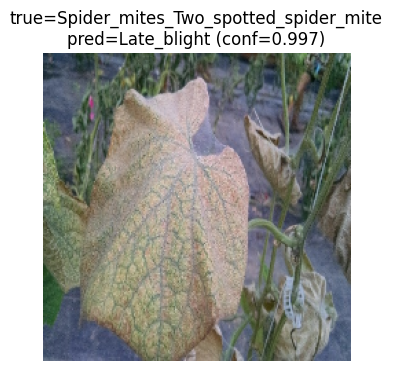

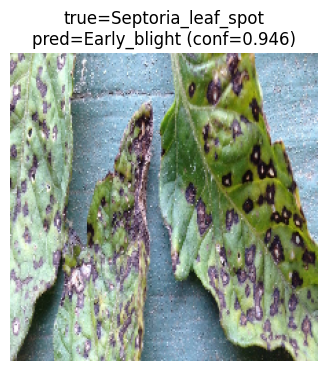

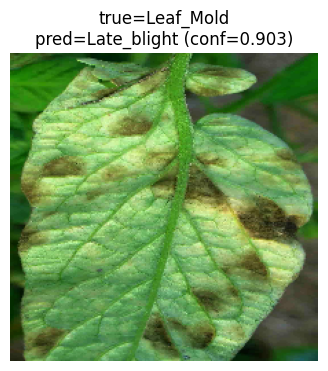

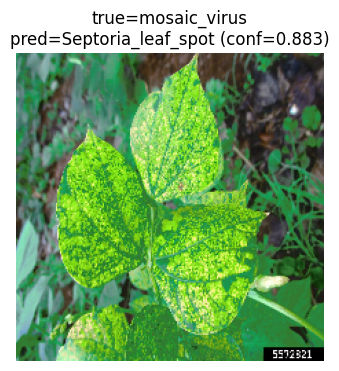

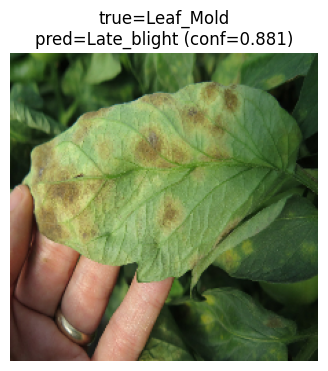

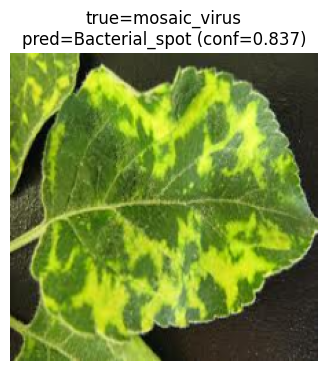


Most uncertain (showing 6)


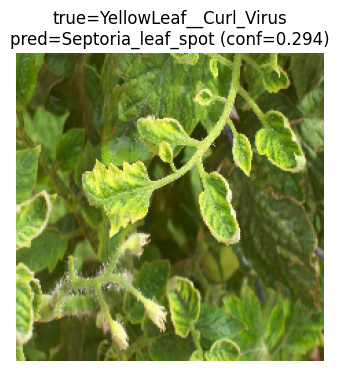

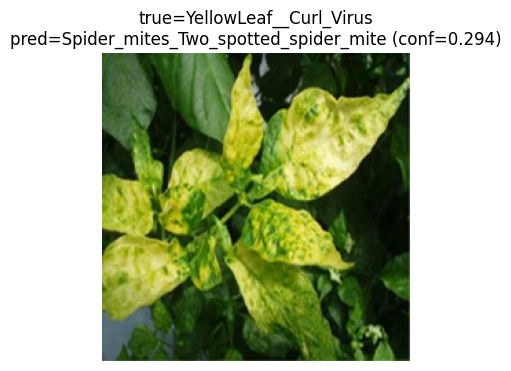

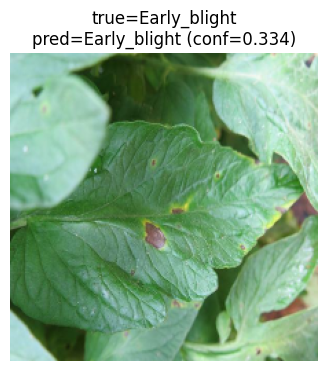

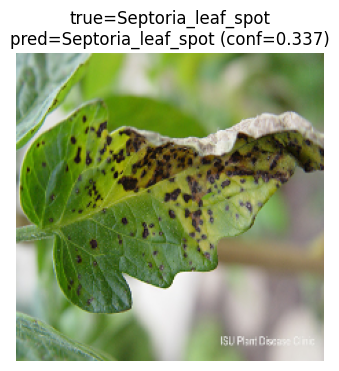

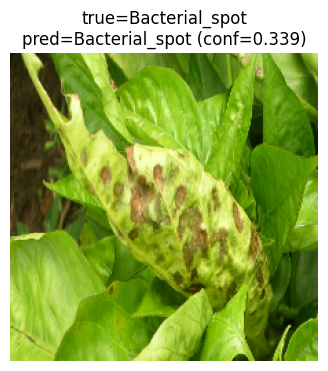

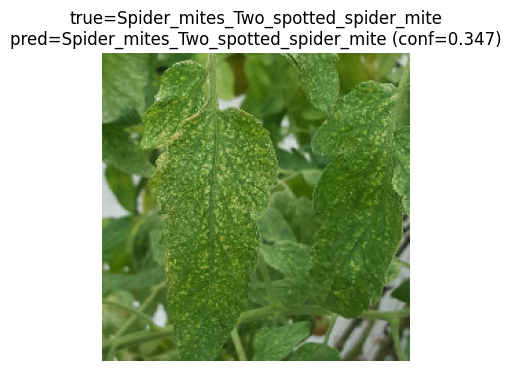

In [20]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

# Build a results table
rows = []
for path, yt, yp, conf, prob_vec in zip(img_paths, y_true, y_pred, y_pred_conf, probs_all):
    top3_idx = prob_vec.argsort()[-3:][::-1]
    top3 = [(class_names[i], float(prob_vec[i])) for i in top3_idx]
    rows.append({
        "path": str(path),
        "file": Path(path).name,
        "true": class_names[int(yt)],
        "pred": class_names[int(yp)],
        "conf": float(conf),
        "top3": top3
    })

df = pd.DataFrame(rows)
df["correct"] = df["true"] == df["pred"]

print("Total wild images:", len(df))
print("Correct:", int(df["correct"].sum()), "| Wrong:", int((~df["correct"]).sum()))

# --- 1) Confident but wrong (most important failures)
confident_wrong = df[~df["correct"]].sort_values("conf", ascending=False).head(12)

print("\n=== Confident but wrong (top 12) ===")
display(confident_wrong[["file", "true", "pred", "conf", "top3", "path"]])

# --- 2) Most uncertain predictions (lowest confidence) - often ambiguous images
most_uncertain = df.sort_values("conf", ascending=True).head(12)

print("\n=== Most uncertain (lowest confidence, top 12) ===")
display(most_uncertain[["file", "true", "pred", "conf", "top3", "path"]])

# --- 3) Optional: show images inline
SHOW_IMAGES = True

def show_examples(subdf, title, n=6):
    if len(subdf) == 0:
        print(f"\n{title}: none")
        return
    n = min(n, len(subdf))
    print(f"\n{title} (showing {n})")
    for _, r in subdf.head(n).iterrows():
        img = load_one_image(Path(r["path"]))  # Tensor (256,256,3), float32
        img = tf.cast(tf.clip_by_value(img / 255.0, 0, 1), tf.float32)  # for display only
        plt.figure(figsize=(4, 4))
        plt.imshow(img.numpy())
        plt.axis("off")
        plt.title(f"true={r['true']}\npred={r['pred']} (conf={r['conf']:.3f})")
        plt.show()

if SHOW_IMAGES:
    show_examples(confident_wrong, "Confident but wrong")
    show_examples(most_uncertain, "Most uncertain")


Saving the results of "confident but wrong".

In [11]:
from pathlib import Path

OUT_DIR = Path("../reports")   # or wherever you like
OUT_DIR.mkdir(parents=True, exist_ok=True)

confident_wrong = df[~df["correct"]].sort_values("conf", ascending=False)

out_path = OUT_DIR / "wild_confident_wrong.csv"
confident_wrong.to_csv(out_path, index=False)

print("Saved:", out_path.resolve())
print("Rows:", len(confident_wrong))


Saved: C:\Users\ogina\Desktop\DS_Bootcamp\Capstone_Project\image_clasification_model\reports\wild_confident_wrong.csv
Rows: 35


In [12]:
(df.sort_values("conf", ascending=False)
   .to_csv(OUT_DIR / "wild_all_predictions.csv", index=False))
